In [1]:
#get larlite
from larlite import larlite as ll
from larlite import larutil as lu

geo=lu.Geometry.GetME()
geoH=lu.GeometryHelper.GetME()

import ROOT

In [2]:
#graphics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import root_numpy as rn
import pandas as pd
%matplotlib inline

/Library/Python/2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.8.0rc1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [3]:
#create storage manager
sm = ll.storage_manager()
sm.set_io_mode(ll.storage_manager.kREAD)
FILENAME="mcc8_post_pi0cut.root"
sm.add_in_filename(FILENAME)
sm.open()

True

In [31]:
SCE = lu.SpaceChargeMicroBooNE()

STARTING! 
~~~~~~~~~~~> event is 0 <~~~~~~~~~~~


/Library/Python/2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: overflow encountered in square


               E  MPDG          X          Y           Z
149  3631.312726   111  84.198868 -40.165554  293.046936
150  3632.451035   111  79.526413 -25.402344  328.964355


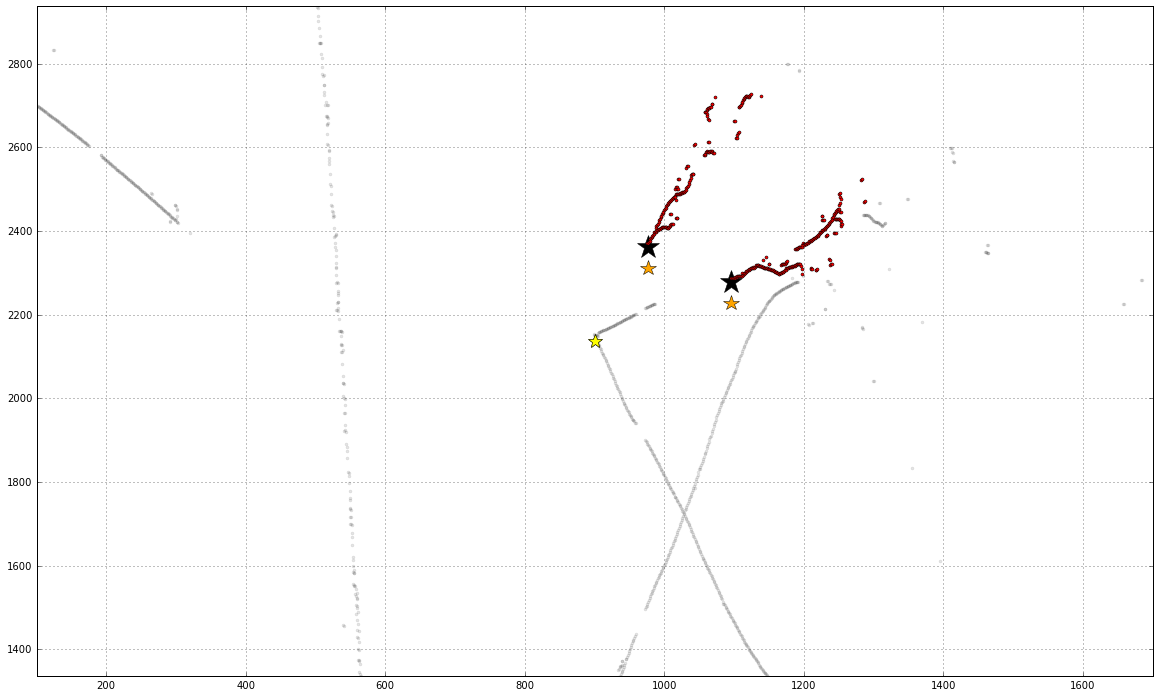

In [29]:
print "STARTING! "
#for evt in xrange(1050):
while True:
    evt = 0
    print "~~~~~~~~~~~> event is %d <~~~~~~~~~~~"%evt
    
    sm.go_to(evt)

    #get hits and clusters
    event_hits     = sm.get_data(ll.data.kHit,"gaushit")
    event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")
    event_showers = sm.get_data(ll.data.kShower,"showerreco")
    event_mcshowers = sm.get_data(ll.data.kMCShower,"mcreco")
    event_vertex = sm.get_data(ll.data.kVertex,"numuCC_vertex")

    #get ass
    event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")
    #get association
    cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())

    mcshowerdata = rn.root2array(FILENAME,
                            treename='mcshower_mcreco_tree',
                            branches=['mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.X()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Y()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Z()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Energy()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fMotherPDGCode'])
                                      
    mcs_df= pd.DataFrame({'X'   : mcshowerdata[evt][0],
                          'Y'   : mcshowerdata[evt][1],
                          'Z'   : mcshowerdata[evt][2],
                          'E'   : mcshowerdata[evt][3],
                          'MPDG' : mcshowerdata[evt][4]})

    mcs_df_pi0 = mcs_df.query('E > 0 and E < 1e20 and X > 20 and X < 236.35 and Y > -96.5 and Y < 96.5 \
                             and Z > 10 and Z < 1026.7 and MPDG == 111')
    
    
#     vtxtick = (tvtx / 1000.) * 2.; // time in tick :
#     vtxtimecm = vtxtick * _time2cm; // time in cm :
#     sce_corr = _SCE->GetPosOffsets(xvtx,yvtx,zvtx);
#     mcs_df_pi0['Xcorr'] = mcs_df_pi0['X'] + vtxtimecm - sce_corr.at(0); 
#     mcs_df_pi0['Ycorr'] = mcs_df_pi0['X'] + vtxtimecm - sce_corr.at(0); 
#     mcs_df_pi0['Zcorr'] = mcs_df_pi0['X'] + vtxtimecm - sce_corr.at(0); 
    
    #print "FIRST SHAPE " , mcs_df_pi0.shape
    #print mcs_df_pi0
    
    vtx=ROOT.std.vector('double')()
    vtx.resize(3)
    vtx[0]=event_vertex[0].X()
    vtx[1]=event_vertex[0].Y()
    vtx[2]=event_vertex[0].Z()

    mcs_df['vtx_x'] = vtx[0]
    mcs_df['vtx_y'] = vtx[1] 
    mcs_df['vtx_z'] = vtx[2] 
    mcs_df['diff'] = np.sqrt( pow(mcs_df.vtx_x.values - mcs_df.X.values,2) + \
                               pow(mcs_df.vtx_y.values - mcs_df.Y.values,2) + \
                               pow(mcs_df.vtx_z.values - mcs_df.Z.values,2) )
     
    gausdata = rn.root2array(FILENAME,
                            treename='hit_gaushit_tree',
                            branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

    hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                           'PeakTime'  : gausdata[evt][0],
                           'Plane'     : gausdata[evt][2]})

    
    showerdata = rn.root2array(FILENAME,
                            treename='shower_showerreco_tree',
                            branches=['shower_showerreco_branch.vector<larlite::shower>.fXYZstart.x()',
                                      'shower_showerreco_branch.vector<larlite::shower>.fXYZstart.y()',
                                      'shower_showerreco_branch.vector<larlite::shower>.fXYZstart.z()'])
                                      
    showers_df= pd.DataFrame({'X'   : showerdata[evt][0],
                              'Y'   : showerdata[evt][1],
                              'Z'   : showerdata[evt][2]
                             })
    
    print mcs_df_pi0

    for plane in [2]: #[0,1,2]:

        fig,ax=plt.subplots(figsize=(10*2,6*2))

        phits = hits_df.query("Plane=={}".format(plane))

        ax.plot(phits.Wire,phits.PeakTime,'o',color='black',markersize=3,alpha=0.1)
    
        for i in xrange(showers_df.shape[0]):
            shr=ROOT.std.vector('double')()
            shr.resize(3)
            shr[0]=showers_df.X.values[i]
            shr[1]=showers_df.Y.values[i]
            shr[2]=showers_df.Z.values[i]
            px = geoH.Point_3Dto2D(shr.data(),plane)
            
            pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
            ax.plot(pt[0],pt[1],'*',markersize=24,color='k')
            
        for i in xrange(mcs_df_pi0.shape[0]):
            shr=ROOT.std.vector('double')()
            shr.resize(3)
            shr[0]=mcs_df_pi0.X.values[i]
            shr[1]=mcs_df_pi0.Y.values[i]
            shr[2]=mcs_df_pi0.Z.values[i]
            px = geoH.Point_3Dto2D(shr.data(),plane)
       
            pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
            ax.plot(pt[0],pt[1],'*',markersize=16,color='orange')
    
        # plot each cluster and userinfo
        for ix,cluster in enumerate(cluster_to_hit_ass):

            ##############################
            #get the hits for this clusters
            slice_=np.array(cluster)
            if event_clusters[ix].Plane().Plane != plane: continue
            if slice_.size == 0: continue

            hslice = hits_df.iloc[slice_]
            ax.plot(hslice.Wire,hslice.PeakTime,'o',color='red',markersize=3)

            cid = event_clusters[ix].ID()

            #put vertex information on screen as a big star 
            px = geoH.Point_3Dto2D(vtx.data(),plane)
            pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])

            ax.plot(pt[0],pt[1],'*',markersize=15,color='yellow')
            ax.set_xlim(pt[0]-800,pt[0]+800)
            ax.set_ylim(pt[1]-800,pt[1]+800)
            
        plt.grid()
        plt.show()
    break

In [ ]:
GOOD EXAMPLE, Evt0